# Quantify cell region morphology - part 1.4
--------------------

## OVERVIEW
Now that all organelles and masks are segmented, we can begin to quantify features of organelle composition, morphology, interactions, and distribution. 


## OBJECTIVE: ✅ Quantify ***cell region*** morphology
In this notebook, the logic for quantifying cell regions - ***cell***, ***nucleus***, and ***cytoplasm*** - composition (how much of each region is present) and morphology (region size and shape) is outlined.



## IMPORTS

In [1]:
# top level imports
from pathlib import Path
import os, sys
import itertools

import parse

import napari

from skimage.measure import (regionprops, _regionprops, regionprops_table)

from napari.utils.notebook_display import nbscreenshot

### import local python functions in ../infer_subc
sys.path.append(os.path.abspath((os.path.join(os.getcwd(), '..'))))

from infer_subc.core.file_io import (read_czi_image,
                                        export_inferred_organelle,
                                        import_inferred_organelle,
                                        export_tiff,
                                        list_image_files)

from infer_subc.core.img import *
from infer_subc.utils.stats import *
from infer_subc.utils.stats import (_my_props_to_dict, _assert_uint16_labels)
from infer_subc.utils.stats_helpers import *

from infer_subc.organelles import * 

from infer_subc.constants import (TEST_IMG_N,
                                    NUC_CH ,
                                    LYSO_CH ,
                                    MITO_CH ,
                                    GOLGI_CH ,
                                    PEROX_CH ,
                                    ER_CH ,
                                    LD_CH ,
                                    RESIDUAL_CH ) 

import time
%load_ext autoreload
%autoreload 2

## Get and load image for quantification
Specifically, this will include the raw image and the outputs from segmentation.

In [2]:
test_img_n = TEST_IMG_N

data_root_path = Path(os.path.expanduser("~")) / "Documents/Python_Scripts/Infer-subc"

raw_data_path = data_root_path / "raw"
im_type = ".czi"

raw_file_list = list_image_files(raw_data_path,im_type)
raw_img_name = raw_file_list[test_img_n]

# adding an additional list of image paths for the matching segmentation files
seg_data_path = data_root_path / "out"
seg_file_list = list_image_files(seg_data_path, "tiff")

# changing output directory for this notebook to a new folder called "quant"
out_data_path = data_root_path / "quant"
if not Path.exists(out_data_path):
    Path.mkdir(out_data_path)
    print(f"making {out_data_path}")

In [3]:
# raw image
raw_img_data, raw_meta_dict = read_czi_image(raw_img_name)

channel_names = raw_meta_dict['name']
img = raw_meta_dict['metadata']['aicsimage']
scale = raw_meta_dict['scale']
channel_axis = raw_meta_dict['channel_axis']

In [4]:
## For each import, change the string to match the suffix on the segmentation files (i.e., the stuff following the "-")

# masks
nuc_seg = import_inferred_organelle("20230426_test_nuc", raw_meta_dict, seg_data_path)
cell_seg = import_inferred_organelle("20230426_test_cell", raw_meta_dict, seg_data_path)
cyto_seg = import_inferred_organelle("20230426_test_cyto", raw_meta_dict, seg_data_path)
# mask_seg = import_inferred_organelle("masks", raw_meta_dict, seg_data_path)

loaded  inferred 3D `20230426_test_nuc`  from C:\Users\Shannon\Documents\Python_Scripts\Infer-subc\out 
loaded  inferred 3D `20230426_test_cell`  from C:\Users\Shannon\Documents\Python_Scripts\Infer-subc\out 
loaded  inferred 3D `20230426_test_cyto`  from C:\Users\Shannon\Documents\Python_Scripts\Infer-subc\out 


-------------------------
## Visualize the image and segmentation outputs

In [5]:
viewer = napari.Viewer()

25-Oct-23 15:39:07 - vispy    - WARNING  - QWindowsWindow::setGeometry: Unable to set geometry 1086x657+636+256 (frame: 1104x704+627+218) on QWidgetWindow/"_QtMainWindowClassWindow" on "\\.\DISPLAY1". Resulting geometry: 905x825+634+249 (frame: 923x872+625+211) margins: 9, 38, 9, 9 minimum size: 385x515 MINMAXINFO maxSize=0,0 maxpos=0,0 mintrack=403,562 maxtrack=0,0)


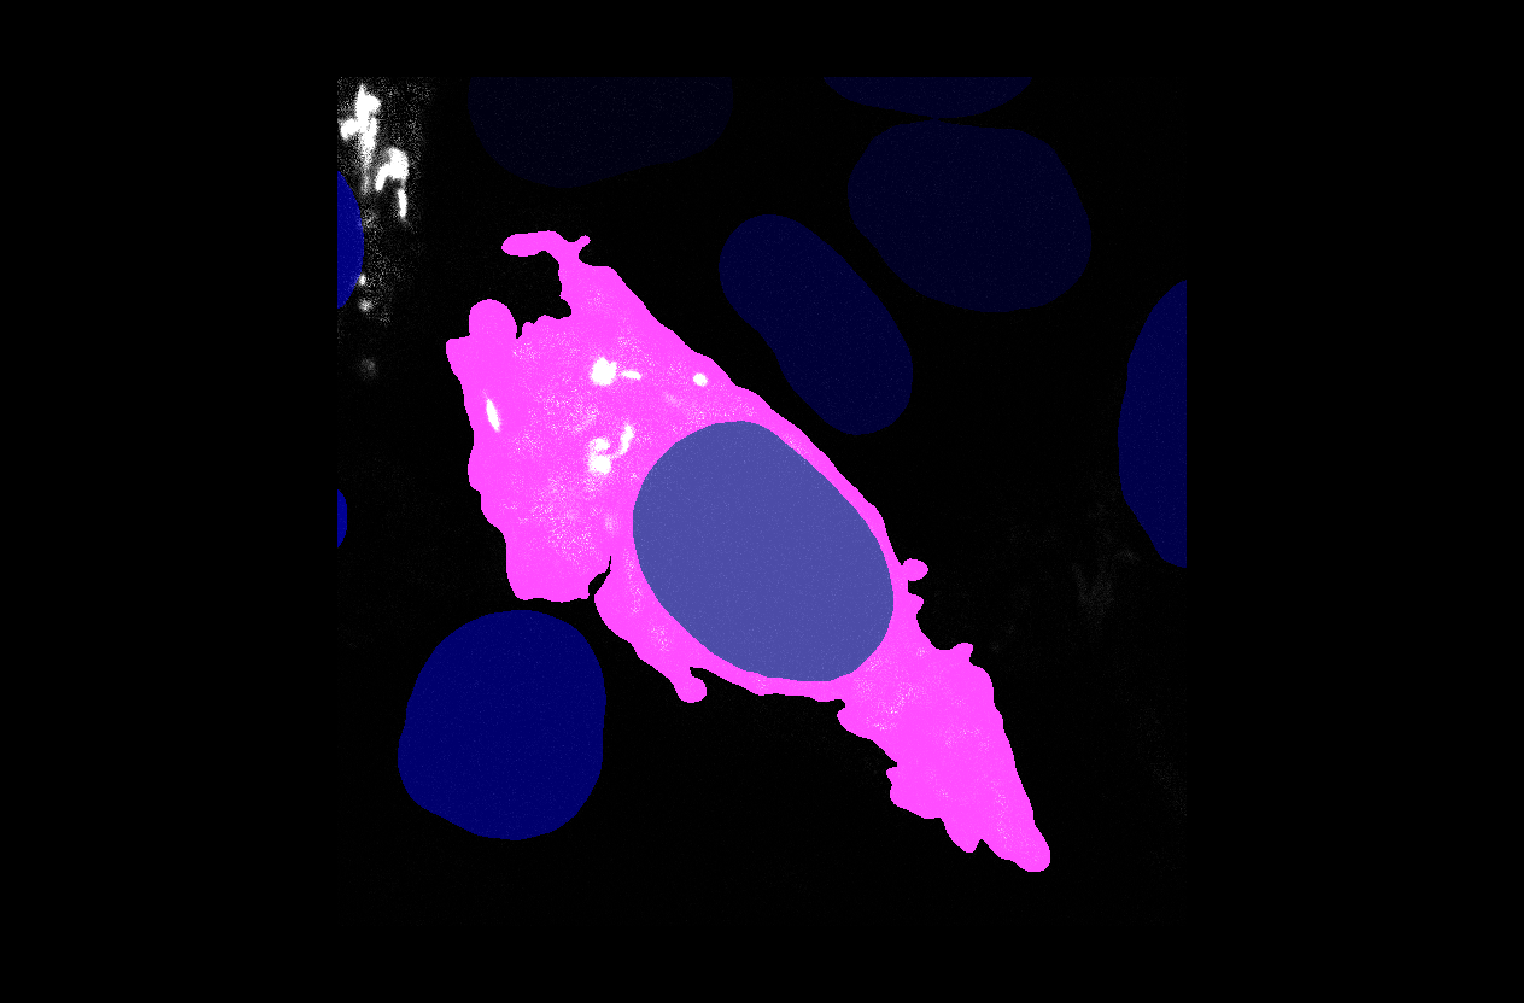

In [6]:
viewer.add_image(raw_img_data)
viewer.add_image(cell_seg, colormap='gray', opacity=0.3, blending ='additive')
viewer.add_image(nuc_seg, colormap='blue', blending ='additive')
viewer.add_image(cyto_seg, colormap='magenta', blending ='additive')

nbscreenshot(viewer, canvas_only=True)

In [7]:
viewer.close()

---------
## **Organelle Morphology**

### summary of steps

🛠️ BUILD FUNCTION PROTOTYPE

- **`0`** - Apply Cell Mask *(preliminary step)*

- **`1`** - Build the list of measurements we want to include from regionprops 

- **`2`** - Add additional measurements as *"extra_properties"* with custom functions

    - define a function to retrieve the standard deviation of the region's intensity values

- **`3`** - Run regionprops and export values as a pandas dataframe

- **`4`** - Add additional measurements
    - surface area
    - surface area to volume ratio

⚙️ EXECUTE FUNCTION PROTOTYPE

- Define `_get_org_morphology_3D` function
- Run `_get_org_morphology_3D` function
- Compare to finalized `get_org_morphology_3D` function

-------------------------
# **regionprops**

To measure the amount, size, and shape of the cell regions - ***cell***, ***nucleus***, and ***cytoplasm***, we will utilize `skimage.measure.regionprops`. These measurements can be collected based on pixel/voxel units (assuming the image is isotropic in all dimensions) and or "real-world" units (e.g., microns). Since most confocal microscope images are anisotropic (mostly with respect to the Z dimension), we will preferentially utilize real-world units. Luckily, regionprops>=0.20.0 has incorporated a spacing parameter that can handle anisotropic data.

We will utilize the same concepts outlined in notebook 1.1_organelle_morphology.ipynb.

# ***BUILD FUNCTION PROTOTYPE***

## **`0` - Apply Cell Mask *(preliminary step)***
To ensure we are performing single cell analysis, we will apply the cell segmentation as a mask.

In [8]:
nuc_masked = apply_mask(nuc_seg, cell_seg)

## **`1` - Build the list of measurements we want to include from regionprops**

In [9]:
# start with LABEL
test_properties = ["label"]

# add position
test_properties = test_properties + ["centroid", "bbox"]

# add area
test_properties = test_properties + ["area", "equivalent_diameter"] # "num_pixels", 

# add shape measurements
test_properties = test_properties + ["extent", "euler_number", "solidity", "axis_major_length"] # "feret_diameter_max", "axis_minor_length"]

# add intensity values (used for quality checks only)
test_properties = test_properties + ["min_intensity", "max_intensity", "mean_intensity"]

## **`2` - Add additional measurements as *"extra_properties"* with custom functions**

- define a function to retrieve the standard deviation of the region's intensity values

In [10]:
def standard_deviation_intensity(region, intensities):
    return np.std(intensities[region])

test_extra_properties = [standard_deviation_intensity]

## **`3` - Run regionprops and export values as a pandas dataframe**

In [12]:
# regionprops wants the intensity image in XYZ instead of ZYX order
test_intensity_input = np.moveaxis(raw_img_data, 0, -1)

test_props = regionprops_table(label_image=nuc_masked, 
                               intensity_image=test_intensity_input, 
                               properties=test_properties, 
                               extra_properties=test_extra_properties,
                               spacing=scale)

test_props_table = pd.DataFrame(test_props)

In [13]:
test_region_name = 'nuc'

test_props_table.insert(0, "object", test_region_name)
test_props_table.rename(columns={"area": "volume"}, inplace=True)

round_scale = (round(scale[0], 4), round(scale[1], 4), round(scale[2], 4))
test_props_table.insert(loc=2, column="scale", value=f"{round_scale}")

In [17]:
#renaming intensity quantification with the channel names
test_channel_name = ["nuc", "lyso", "mito", "golgi", "perox", "ER", "LD", "residual"]

test_rename_dict = {}
for test_col in test_props_table.columns:
    for test_idx, test_name in enumerate(test_channel_name):
        if test_col.endswith(f"intensity-{test_idx}"):
            test_rename_dict[f"{test_col}"] = f"{test_col[:-1]}{test_name}_ch"

test_props_renames = test_props_table.rename(columns=test_rename_dict)

test_props_renames

,object,label,scale,centroid-0,centroid-1,centroid-2,bbox-0,bbox-1,bbox-2,bbox-3,bbox-4,bbox-5,volume,equivalent_diameter,extent,euler_number,solidity,axis_major_length,min_intensity-nuc_ch,min_intensity-lyso_ch,min_intensity-mito_ch,min_intensity-golgi_ch,min_intensity-perox_ch,min_intensity-ER_ch,min_intensity-LD_ch,min_intensity-residual_ch,max_intensity-nuc_ch,max_intensity-lyso_ch,max_intensity-mito_ch,max_intensity-golgi_ch,max_intensity-perox_ch,max_intensity-ER_ch,max_intensity-LD_ch,max_intensity-residual_ch,mean_intensity-nuc_ch,mean_intensity-lyso_ch,mean_intensity-mito_ch,mean_intensity-golgi_ch,mean_intensity-perox_ch,mean_intensity-ER_ch,mean_intensity-LD_ch,mean_intensity-residual_ch,standard_deviation_intensity-nuc_ch,standard_deviation_intensity-lyso_ch,standard_deviation_intensity-mito_ch,standard_deviation_intensity-golgi_ch,standard_deviation_intensity-perox_ch,standard_deviation_intensity-ER_ch,standard_deviation_intensity-LD_ch,standard_deviation_intensity-residual_ch
0,nuc,5,"(0.3891, 0.0799, 0.0799)",2.628936,31.602057,28.150081,0,284,242,16,504,463,1037.508176,12.560231,0.537266,1,0.913476,21.135161,0.0,0.0,0.0,0.0,0.0,0.0,0.0,446.0,8392.0,20433.0,15222.0,15249.0,15353.0,19653.0,7637.0,18477.0,2012.255031,367.603307,159.087391,236.961146,473.744757,1447.220691,357.386144,4216.287242,1048.054565,652.078905,453.954104,496.54118,887.180795,1842.257956,442.751818,1645.622597


## **`4` - Add additional measurements**

- surface area
- surface area to volume ratio

In [18]:
# props["surface_area"] = surface_area_from_props(nuc_seg, props)
test_surface_area_tab = pd.DataFrame(surface_area_from_props(nuc_masked, test_props, scale))

test_props_renames.insert(12, "surface_area", test_surface_area_tab)
test_props_renames.insert(14, "SA_to_volume_ratio", test_props_renames["surface_area"].div(test_props_renames["volume"]))

pd.set_option('display.max_columns', None)

test_props_renames

,object,label,scale,centroid-0,centroid-1,centroid-2,bbox-0,bbox-1,bbox-2,bbox-3,bbox-4,bbox-5,surface_area,volume,SA_to_volume_ratio,equivalent_diameter,extent,euler_number,solidity,axis_major_length,min_intensity-nuc_ch,min_intensity-lyso_ch,min_intensity-mito_ch,min_intensity-golgi_ch,min_intensity-perox_ch,min_intensity-ER_ch,min_intensity-LD_ch,min_intensity-residual_ch,max_intensity-nuc_ch,max_intensity-lyso_ch,max_intensity-mito_ch,max_intensity-golgi_ch,max_intensity-perox_ch,max_intensity-ER_ch,max_intensity-LD_ch,max_intensity-residual_ch,mean_intensity-nuc_ch,mean_intensity-lyso_ch,mean_intensity-mito_ch,mean_intensity-golgi_ch,mean_intensity-perox_ch,mean_intensity-ER_ch,mean_intensity-LD_ch,mean_intensity-residual_ch,standard_deviation_intensity-nuc_ch,standard_deviation_intensity-lyso_ch,standard_deviation_intensity-mito_ch,standard_deviation_intensity-golgi_ch,standard_deviation_intensity-perox_ch,standard_deviation_intensity-ER_ch,standard_deviation_intensity-LD_ch,standard_deviation_intensity-residual_ch
0,nuc,5,"(0.3891, 0.0799, 0.0799)",2.628936,31.602057,28.150081,0,284,242,16,504,463,650.256734,1037.508176,0.626749,12.560231,0.537266,1,0.913476,21.135161,0.0,0.0,0.0,0.0,0.0,0.0,0.0,446.0,8392.0,20433.0,15222.0,15249.0,15353.0,19653.0,7637.0,18477.0,2012.255031,367.603307,159.087391,236.961146,473.744757,1447.220691,357.386144,4216.287242,1048.054565,652.078905,453.954104,496.54118,887.180795,1842.257956,442.751818,1645.622597


# ***EXECUTE FUNCTION PROTOTYPE***

## **Define `_get_org_morphology_3D` function**

Based on the _prototyping_ above define the function to quantify amount, size, and shape of the cell regions.

In [28]:
def _get_region_morphology_3D(region_seg: np.ndarray, 
                              region_name: str,
                              intensity_img: np.ndarray, 
                              channel_names: [str],
                              mask: np.ndarray, 
                              scale: Union[tuple, None]=None) -> Tuple[Any, Any]:
    """
    Parameters
    ------------
    segmentation_img:
        a list of all 3d np.ndarray images of the segemented cell regions (e.g., whole cell, nucleus, cytoplasm, etc.)
    names:
        names or nicknames for the cell regions being analyzed
    intensity_img:
        a 3d np.ndarray image of the "raw" florescence intensity the segmentation was based on; for our use, this is the raw image with all the channels
        we will measure the intensity within the cell region being analyzed
    mask:
        a 3d np.ndarray image of the cell mask (or other mask of choice); used to create a "single cell" analysis

    Returns
    -------------
    pandas dataframe of containing regionprops measurements (columns) for each object in the segmentation image (rows) and the regionprops object

    """
    if len(channel_names) != intensity_img.shape[0]:
        ValueError("You have not provided a name for each channel in the intensity image. Make sure there is a channel name for each channel in the intensity image.")
    
    ###################################################
    ## MASK THE REGION OBJECTS THAT WILL BE MEASURED
    ###################################################
    # in case we sent a boolean mask (e.g. cyto, nucleus, cellmask)
    input_labels = _assert_uint16_labels(region_seg)

    input_labels = apply_mask(input_labels, mask)

    ##########################################
    ## CREATE LIST OF REGIONPROPS MEASUREMENTS
    ##########################################
    # start with LABEL
    properties = ["label"]
    # add position
    properties = properties + ["centroid", "bbox"]
    # add area
    properties = properties + ["area", "equivalent_diameter"] # "num_pixels", 
    # add shape measurements
    properties = properties + ["extent", "euler_number", "solidity", "axis_major_length"] # ,"feret_diameter_max", , "axis_minor_length"]
    # add intensity values (used for quality checks)
    properties = properties + ["min_intensity", "max_intensity", "mean_intensity"]

    #######################
    ## ADD EXTRA PROPERTIES
    #######################
    def standard_deviation_intensity(region, intensities):
        return np.std(intensities[region])

    extra_properties = [standard_deviation_intensity]

    ##################
    ## RUN REGIONPROPS
    ##################
    intensity_input = np.moveaxis(intensity_img, 0, -1)

    rp = regionprops(input_labels, 
                    intensity_image=intensity_input, 
                    extra_properties=extra_properties, 
                    spacing=scale)

    props = regionprops_table(label_image=input_labels, 
                              intensity_image=intensity_input, 
                              properties=properties, 
                              extra_properties=extra_properties,
                              spacing=scale)

    props_table = pd.DataFrame(props)
    props_table.insert(0, "object", region_name)
    props_table.rename(columns={"area": "volume"}, inplace=True)

    if scale is not None:
        round_scale = (round(scale[0], 4), round(scale[1], 4), round(scale[2], 4))
        props_table.insert(loc=2, column="scale", value=f"{round_scale}")
    else: 
        props_table.insert(loc=2, column="scale", value=f"{tuple(np.ones(region_seg.ndim))}") 

    rename_dict = {}
    for col in props_table.columns:
        for idx, name in enumerate(channel_names):
            if col.endswith(f"intensity-{idx}"):
                rename_dict[f"{col}"] = f"{col[:-1]}{name}_ch"

    props_table = props_table.rename(columns=rename_dict)

    ##################################################################
    ## RUN SURFACE AREA FUNCTION SEPARATELY AND APPEND THE PROPS_TABLE
    ##################################################################
    surface_area_tab = pd.DataFrame(surface_area_from_props(input_labels, props, scale))

    props_table.insert(12, "surface_area", surface_area_tab)
    props_table.insert(14, "SA_to_volume_ratio", props_table["surface_area"].div(props_table["volume"]))

    ################################################################
    ## ADD SKELETONIZATION OPTION FOR MEASURING LENGTH AND BRANCHING
    ################################################################
    #  # ETC.  skeletonize via cellprofiler /Users/ahenrie/Projects/Imaging/CellProfiler/cellprofiler/modules/morphologicalskeleton.py
    #         if x.volumetric:
    #             y_data = skimage.morphology.skeletonize_3d(x_data)
    # /Users/ahenrie/Projects/Imaging/CellProfiler/cellprofiler/modules/measureobjectskeleton.py

    return props_table

## **Run `_get_org_morphology_3D` function**

In [29]:
region_seg = nuc_seg
region_name = 'nuc'
intensity_img = raw_img_data
channel_names = test_channel_name
mask = cell_seg 
scale = scale

# with scale
nuc_table = _get_region_morphology_3D(region_seg=region_seg, 
                                      region_name=region_name,
                                      intensity_img=intensity_img,
                                      channel_names=channel_names,
                                      mask=mask,
                                      scale=scale)
nuc_table

,object,label,scale,centroid-0,centroid-1,centroid-2,bbox-0,bbox-1,bbox-2,bbox-3,bbox-4,bbox-5,surface_area,volume,SA_to_volume_ratio,equivalent_diameter,extent,euler_number,solidity,axis_major_length,min_intensity-nuc_ch,min_intensity-lyso_ch,min_intensity-mito_ch,min_intensity-golgi_ch,min_intensity-perox_ch,min_intensity-ER_ch,min_intensity-LD_ch,min_intensity-residual_ch,max_intensity-nuc_ch,max_intensity-lyso_ch,max_intensity-mito_ch,max_intensity-golgi_ch,max_intensity-perox_ch,max_intensity-ER_ch,max_intensity-LD_ch,max_intensity-residual_ch,mean_intensity-nuc_ch,mean_intensity-lyso_ch,mean_intensity-mito_ch,mean_intensity-golgi_ch,mean_intensity-perox_ch,mean_intensity-ER_ch,mean_intensity-LD_ch,mean_intensity-residual_ch,standard_deviation_intensity-nuc_ch,standard_deviation_intensity-lyso_ch,standard_deviation_intensity-mito_ch,standard_deviation_intensity-golgi_ch,standard_deviation_intensity-perox_ch,standard_deviation_intensity-ER_ch,standard_deviation_intensity-LD_ch,standard_deviation_intensity-residual_ch
0,nuc,5,"(0.3891, 0.0799, 0.0799)",2.628936,31.602057,28.150081,0,284,242,16,504,463,650.256734,1037.508176,0.626749,12.560231,0.537266,1,0.913476,21.135161,0.0,0.0,0.0,0.0,0.0,0.0,0.0,446.0,8392.0,20433.0,15222.0,15249.0,15353.0,19653.0,7637.0,18477.0,2012.255031,367.603307,159.087391,236.961146,473.744757,1447.220691,357.386144,4216.287242,1048.054565,652.078905,453.954104,496.54118,887.180795,1842.257956,442.751818,1645.622597


In [31]:
# Will result in FALSE because the _standard_deviation_intensity function was used in the prototyping 
# instead of the standard_deviation_intensity function from stats.py
nuc_table.equals(test_props_renames)

True

## **Compare to finalized `get_org_morphology_3D` function**

In [33]:
from infer_subc.utils.stats import get_region_morphology_3D

nuc_table_final = get_region_morphology_3D(region_seg=region_seg, 
                                            region_name=region_name,
                                            intensity_img=intensity_img,
                                            channel_names=channel_names,
                                            mask=mask,
                                            scale=scale)

In [34]:
nuc_table.equals(nuc_table_final)

True